In [22]:
import cv2

import tensorflow as tf
import keras

tf.__version__, keras.__version__

('2.15.0', '3.0.0')

In [23]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
from utils.layers import PatchEmbedding, PatchMerging, SwinTransformer, WindowAttention

In [25]:
model = tf.keras.models.load_model('../models/swin.keras', custom_objects={
    'PatchEmbedding':PatchEmbedding, 
    'PatchMerging':PatchMerging,
    'SwinTransformer':SwinTransformer,
    'WindowAttention':WindowAttention,        
})
model.summary()

/home/main/.local/lib/python3.11/site-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'patch_embedding_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2024-02-05 17:17:55.428739: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-05 17:17:55.429384: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. S

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 4)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_embedding_1               │ (None, 256, 64)           │     16,704 │
│ (PatchEmbedding)                │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer_2              │ (None, 256, 64)           │     50,072 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer_3              │ (None, 256, 64)           │     51,096 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_merging_1 (PatchMerging)  │ (None, 64, 128)           │     32,768 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling1d_1      │ (None, 128)               │          0 │
│ (GlobalAveragePooling1D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_24 (Dense)                │ (None, 1024)              │    132,096 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_25 (Dense)                │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_26 (Dense)                │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_27 (Dense)                │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,839,925 (10.84 MB)

 Trainable params: 946,289 (3.61 MB)

 Non-trainable params: 1,056 (8.25 KB)

 Optimizer params: 1,892,580 (7.22 MB)

In [26]:
import cv2
import matplotlib.pyplot as plt

input_shape = (32,32,1)

let = cv2.imread('data/letterlist.jpg', 0)
let = let[15:780,:]
num_letters = 33
num_fonts = 21

def get_letter(font_num, letter_num):
    letter = let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]
    return cv2.resize(letter, input_shape[:-1])

def get_letter_variants(letter_num):
        return let[:,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]

def get_font_variants(font_num):
    return let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           :,
           ]
test = get_letter(21,33)
print(test.shape)
plt.imshow(test, cmap='gray')

[ WARN:0@39.544] global loadsave.cpp:248 findDecoder imread_('data/letterlist.jpg'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

In [ ]:
from utils.augmenters import *

images = []
captions = []
captions_base = "Ё Й Ц У К Е Н Г Ш Щ З Х Ъ Ф Ы В А П Р О Л Д Ж Э Я Ч С М И Т Ь Б Ю".split(' ')
for i in range(1, num_fonts+1):
    for j in range(1, num_letters+1):
        images.append(get_letter(i,j))
        captions.append(captions_base[j-1])

aug = MultipleAugmenter(images.copy(), captions.copy())
aug.random_augment(3, 65, 0)


x_data = np.array(aug.images)
x_data = x_data.reshape(*x_data.shape, 1)
classes = list(map(captions_base.index, aug.captions))
y_data = keras.utils.to_categorical(classes, num_classes=num_letters)


In [ ]:
from utils.funcs import patch_extract

def augment(x):
    return x

batch_size = 32

dataset = (
    tf.data.Dataset.from_tensor_slices((x_data, y_data))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [27]:
model.load_weights('../models/swin.weights.h5')

In [ ]:
model.evaluate(dataset)

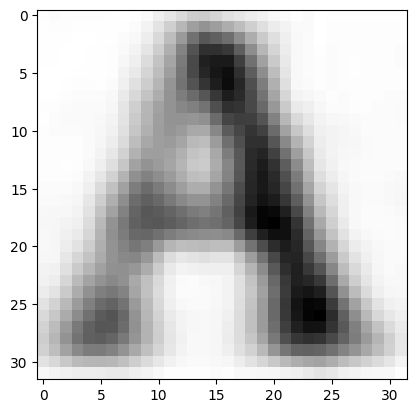

In [28]:
data = []
for i in range(1,97):
    letter = cv2.imread(f'../test/letter{i}.jpg', 0)
    data.append(cv2.resize(letter, input_shape[:-1]))
plt.imshow(data[0], cmap='gray')

In [42]:
data = np.array(data)
data = data[:,:,:, np.newaxis]
data.shape

(96, 32, 32, 1)

In [41]:
from utils.funcs import patch_extract



dataset = (
    tf.data.Dataset.from_tensor_slices(data)
    .batch(batch_size=32)
    .map(lambda x: (patch_extract(x)))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

TypeError: list indices must be integers or slices, not tuple

In [43]:
patch_extract(data)

<tf.Tensor: shape=(96, 256, 4), dtype=uint8, numpy=
array([[[253, 252, 254, 253],
        [253, 253, 253, 254],
        [253, 253, 254, 254],
        ...,
        [207, 215, 244, 246],
        [222, 229, 248, 249],
        [236, 246, 249, 253]],

       [[255, 255, 255, 255],
        [255, 253, 254, 252],
        [251, 248, 248, 243],
        ...,
        [225, 240, 238, 247],
        [252, 255, 253, 255],
        [255, 254, 255, 254]],

       [[255, 236, 253, 225],
        [225, 221, 208, 198],
        [219, 217, 192, 189],
        ...,
        [231, 222, 240, 234],
        [218, 224, 230, 234],
        [239, 255, 244, 255]],

       ...,

       [[255, 254, 255, 254],
        [255, 254, 255, 255],
        [254, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [254, 255, 255, 255],
        [255, 255, 255

In [47]:
pred = model.predict(patch_extract(data)).argmax(axis=0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [49]:
pred

array([28, 28,  0, 28, 28, 28, 28, 28, 28,  0, 28, 28, 28, 28,  0,  8, 28,
       28, 28, 28, 28, 28, 28, 28,  0, 28, 28, 28, 28, 28, 75, 28, 26])